## Kelly Criteriom for asset allocation

Kelly rule has a long history in gambling because it provides guidance on how much to stake on each of an (infinite) sequence of bets with varying (but favorable) odds to maximize terminal wealth. It was published as A New Interpretation of the Information Rate in 1956 by John Kelly who was a colleague of Claude Shannon's at Bell Labs. He was intrigued by bets placed on candidates at the new quiz show The $64,000 Question, where a viewer on the west coast used the three-hour delay to obtain insider information about the winners.

Kelly drew a connection to Shannon's information theory to solve for the bet that is optimal for long-term capital growth when the odds are favorable, but uncertainty remains. His rule maximizes logarithmic wealth as a function of the odds of success of each game, and includes implicit bankruptcy protection since log(0) is negative infinity so that a Kelly gambler would naturally avoid losing everything.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [3]:
import quantstats
from sympy import symbols, solve, log, diff

In [4]:
start_date='2006-01-01'
end_date='2022-06-01'
cost=0.001

In [9]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [10]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [11]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

[__init__] is executed in 3.18 seconds
[__init__] is executed in 3.39 seconds
[__init__] is executed in 3.70 seconds


#### Kelly began by analyzing games with a binary win-lose outcome. The key variables are:
- b: The odds define the amount won for a \$1 bet.
  (odds = 5/1  implies a 5 dollars gain if the bet wins, plus recovery of the 1 dollar capital)
- p: The probability defines the likelihood of a favorable outcome.,
- f: The share of the current capital to bet.
- V: The value of the capital as a result of betting.
#### The Kelly rule aims to maximize the value growth rate(G), for infinitely-repeated bets :
$ G=\lim_{N\rightarrow\infty}\frac{1}{N}log{\frac{V_N}{V_0}} $

In [5]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [6]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

## Kelly Rule for Multiple Assets
 We will use an example with various equities. E. Chan (2008) illustrates how to arrive at a multi-asset application of the Kelly Rule, and that the result is equivalent to the (potentially levered) maximum Sharpe ratio portfolio from the mean-variance optimization.

 The computation involves the dot product of the precision matrix, which is the inverse of the covariance matrix, and the return matrix:


In [54]:
custom_universe = [
    'SPY', # SPDR S&P 500 ETF Trust
    'AGG', # iShares Core U.S. Aggregate Bond ETF 
    'LQD', # iShares iBoxx Investment Grade Corporate Bond ETF
    "RWR", # SPDR® Dow Jones® REIT ETF                             
    "GSG"  # iShares S&P GSCI Commodity Indexed Trust               
    ]


In [55]:
class Kelly(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_3_month_lag = date - relativedelta(months=3)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_3_month_lag : date]
        return_df = return_df/return_df.shift(1)
        return_df = return_df.fillna(1)

        weights = self.kelly_allocation_mp(return_df)

        target = {}
        for i in range(len(tickers)):
            target[tickers[i]] = weights.loc[tickers[i]]

        return target
    
    def kelly_allocation_mp(self, asset_ylds):
        cov = asset_ylds.cov()
        # precision matrix = inverse of covariance matrix, use np.linalg package
        precision_matrix = pd.DataFrame(np.linalg.inv(cov), index=asset_ylds.columns.tolist(), columns=asset_ylds.columns.tolist())
        # average asset yield vector * inverse of covariance matrix
        kelly_allocation = asset_ylds.mean().dot(precision_matrix)
        # If kelly score is negative, replace it with zero
        kelly_allocation[kelly_allocation < 0] = 0
        # Normalize kelly score (w_i/w_sum)
        kelly_allocation = kelly_allocation.div(kelly_allocation.sum())
        return kelly_allocation

    def historical_weight(self):
        historical_portfolio = engine.asset_df
        weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
        for date in historical_portfolio.index:
            for ticker in historical_portfolio.columns:
                weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
        return weight_historical_portfolio 


In [56]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
kelly = Kelly(engine.cache)
engine.run_backtest(target_generator=kelly, sdate=start_date, edate=end_date, transaction_cost=cost)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 6.13 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:1.597 / time elapsed:14.7 =====
[run_backtest] is executed in 14.92 seconds


<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

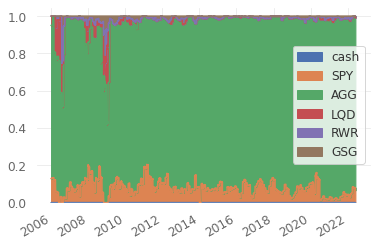

In [57]:
weight_historical_portfolio = kelly.historical_weight()
plt.figure(figsize=(12,8))
weight_historical_portfolio.plot.area(legend=True)

In [58]:
bm_engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
equal = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal, sdate=start_date, edate=end_date, transaction_cost=cost)
bm_strategy = bm_engine.asset_df.sum(axis=1)

[__init__] is executed in 4.92 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.173 / time elapsed:6.3 === date:2007-10-31 00:00:00 / total_asset:1.147 / time elapsed:1.1 === date:2010-09-30 00:00:00 / total_asset:1.111 / time elapsed:2.0 === date:2012-12-31 00:00:00 / total_asset:1.356 / time elapsed:2.7 === / time elapsed:3.8 === / time elapsed:4.0 ===time elapsed:4.5 === / total_asset:1.731 / time elapsed:5.4 ===
[run_backtest] is executed in 6.46 seconds


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          59.86%      117.56%
CAGR﹪                     2.9%        4.85%

Sharpe                     0.55        0.44
Prob. Sharpe Ratio         98.41%      96.18%
Smart Sharpe               0.5         0.4
Sortino                    0.74        0.61
Smart Sortino              0.68        0.56
Sortino/√2                 0.53        0.43
Smart Sortino/√2           0.48        0.39
Omega                      1.13        1.13

Max Drawdown               -18.79%     -41.96%
Longest DD Days            777         1165
Volatility (ann.)          5.45%       12.52%
R^2                        0.32        0.32
Information Ratio          -0.02       -0.02
Calmar                     0.15      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-05-21,2008-11-20,2010-07-07,777,-18.792223,-15.690492
2,2021-08-04,2022-05-06,2022-06-01,301,-10.962379,-10.523596
3,2020-03-09,2020-03-18,2020-04-17,39,-10.561787,-8.624509
4,2013-05-03,2013-09-05,2014-02-03,276,-4.464979,-4.151180
5,2016-09-08,2016-12-15,2017-06-22,287,-4.073344,-3.984038


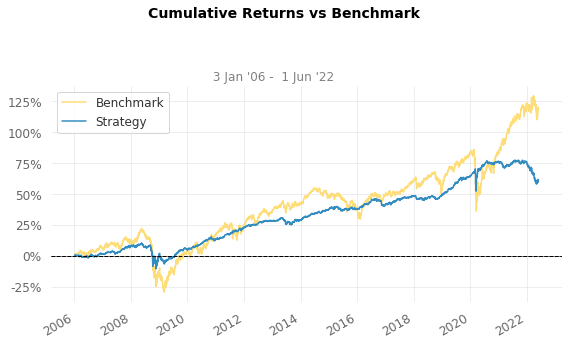

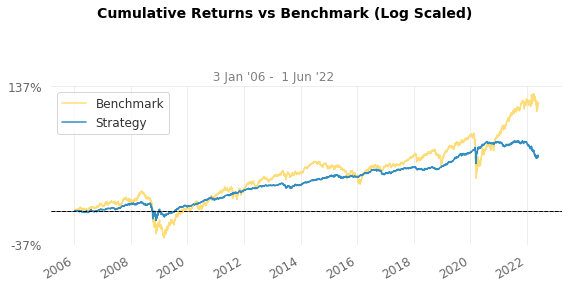

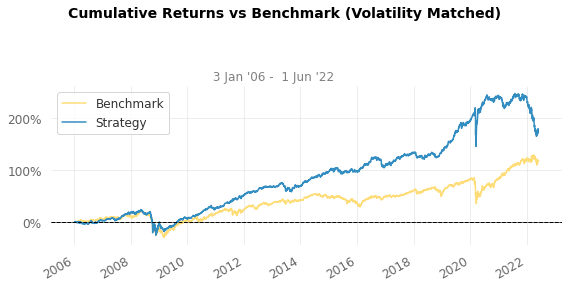

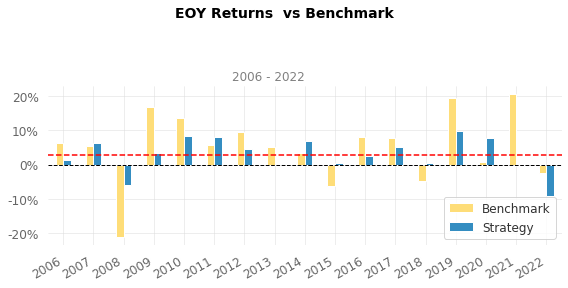

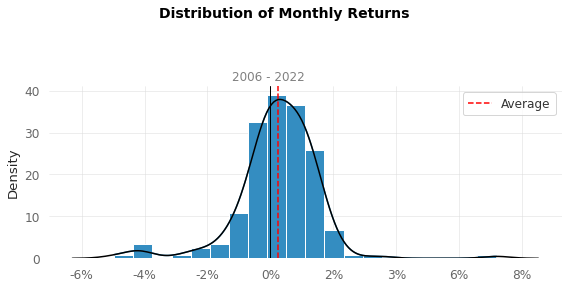

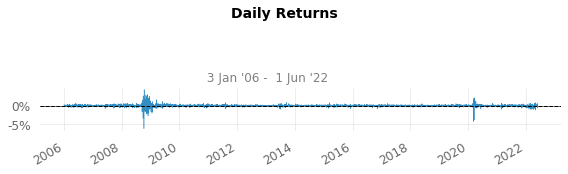

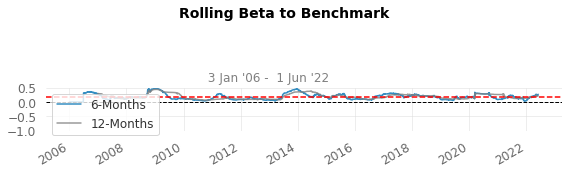

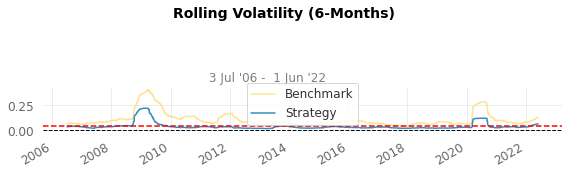

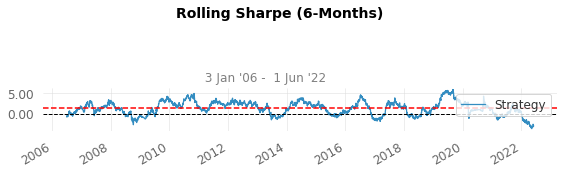

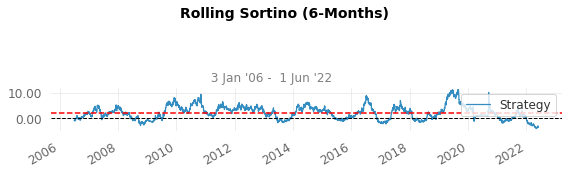

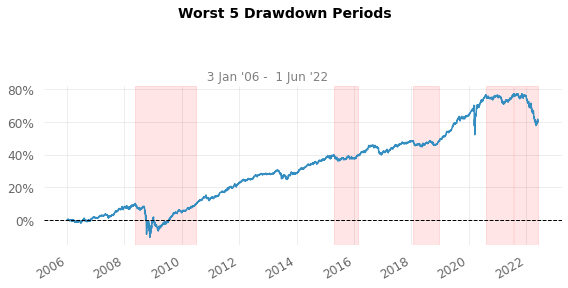

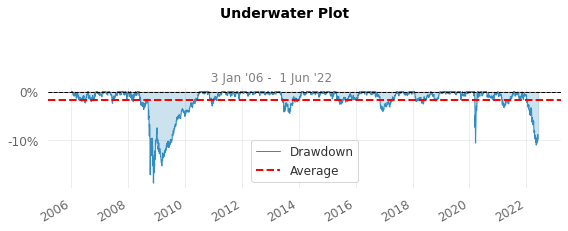

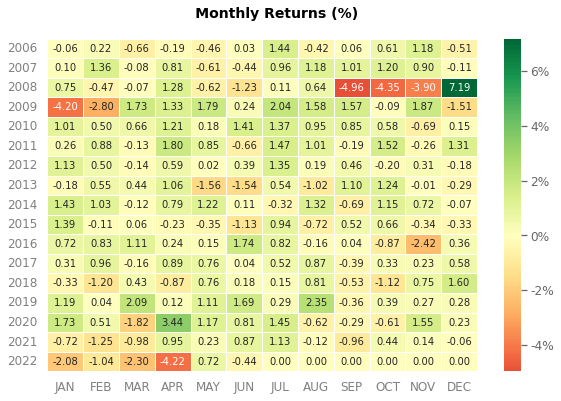

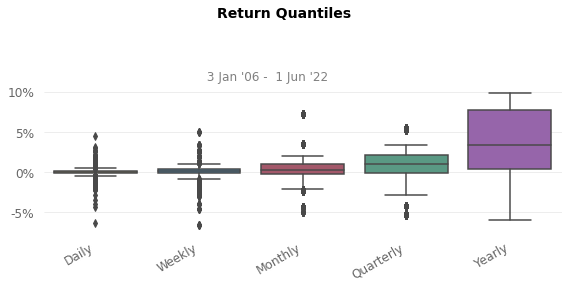

In [59]:
quantstats.reports.full(returns=my_strategy, benchmark=bm_strategy)

In [60]:
custom_universe = [
    "XAR",  # SPDR® S&P® Aerospace & Defense ETF                    2011-09-28
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF             
    ]


In [61]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
kelly = Kelly(engine.cache)
engine.run_backtest(target_generator=kelly, sdate=start_date, edate=end_date, transaction_cost=cost)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 11.17 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:5.537 / time elapsed:35.0 ===
[run_backtest] is executed in 35.62 seconds


<AxesSubplot:>

<Figure size 864x576 with 0 Axes>

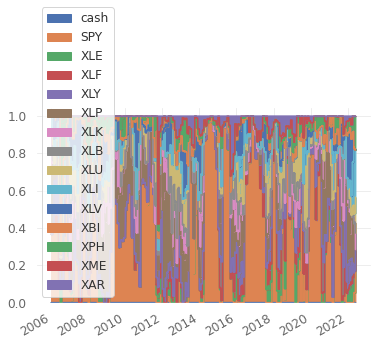

In [64]:
weight_historical_portfolio = kelly.historical_weight()
plt.figure(figsize=(12,8))
weight_historical_portfolio.plot.area(legend=True)

In [62]:
bm_engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
equal = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal, sdate=start_date, edate=end_date, transaction_cost=cost)
bm_strategy = bm_engine.asset_df.sum(axis=1)

[__init__] is executed in 10.54 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:4.543 / time elapsed:11.7 ===
[run_backtest] is executed in 11.89 seconds


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          454.21%     354.74%
CAGR﹪                     10.99%      9.66%

Sharpe                     0.7         0.56
Prob. Sharpe Ratio         99.74%      98.78%
Smart Sharpe               0.63        0.5
Sortino                    0.97        0.78
Smart Sortino              0.87        0.7
Sortino/√2                 0.69        0.55
Smart Sortino/√2           0.62        0.49
Omega                      1.15        1.15

Max Drawdown               -42.99%     -50.77%
Longest DD Days            1042        1119
Volatility (ann.)          17.05%      20.1%
R^2                        0.93        0.93
Information Ratio          0.01        0.01
Calmar                     0.26        0

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-11,2009-03-09,2010-10-18,1042,-42.993294,-39.807035
2,2020-02-20,2020-03-23,2020-08-12,174,-33.833320,-28.965887
3,2018-09-24,2018-12-24,2019-04-30,218,-18.313365,-15.333296
4,2011-05-02,2011-08-08,2012-02-03,277,-16.578365,-15.190889
5,2015-07-21,2016-02-11,2016-07-08,353,-13.171950,-12.413489


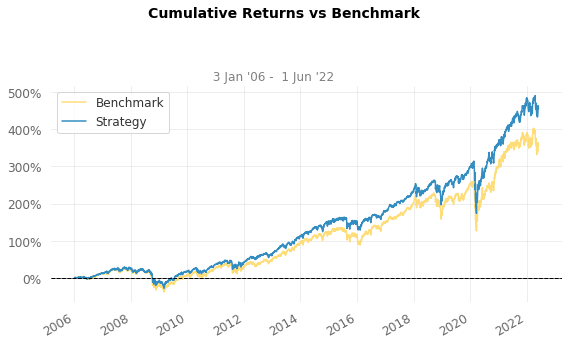

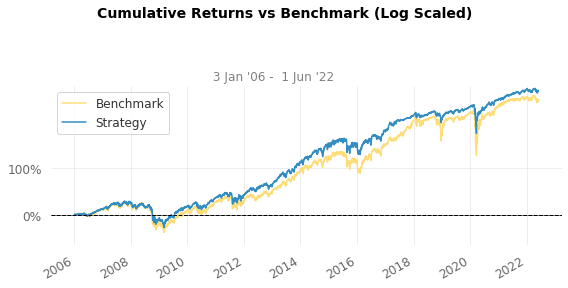

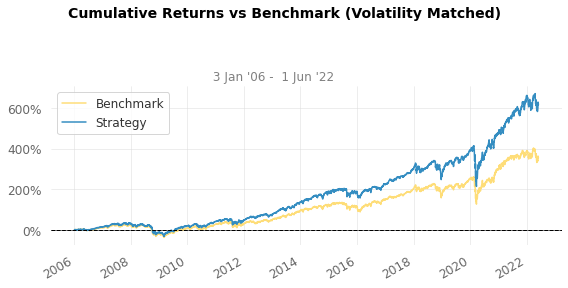

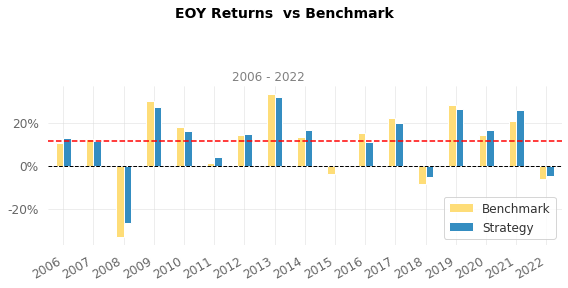

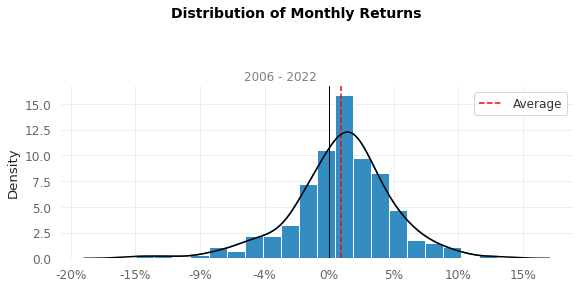

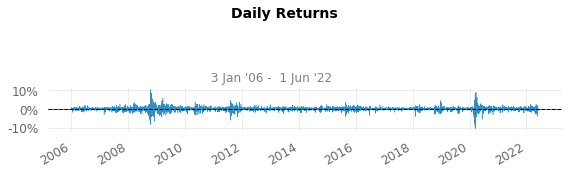

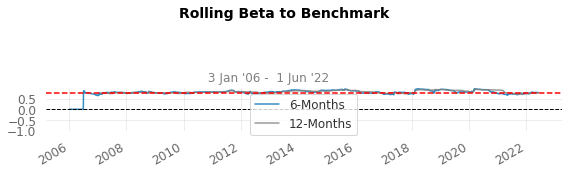

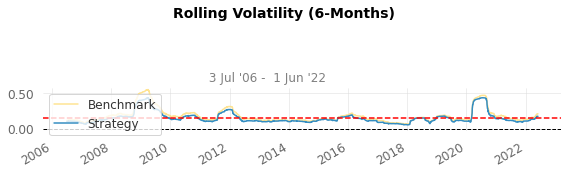

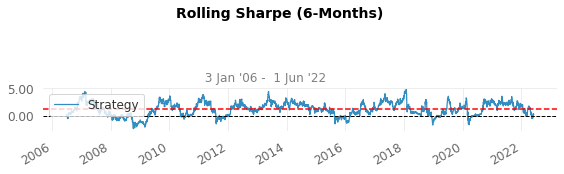

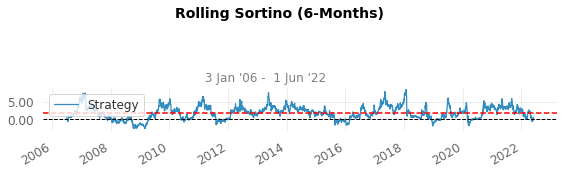

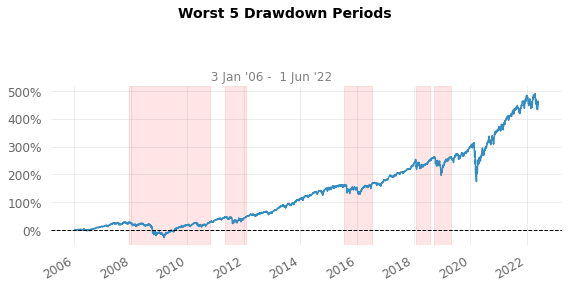

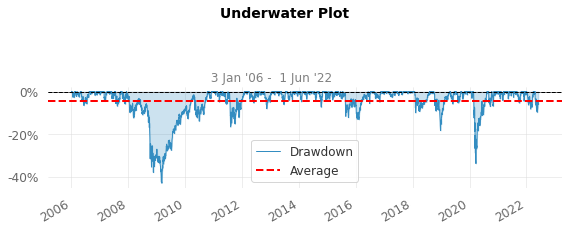

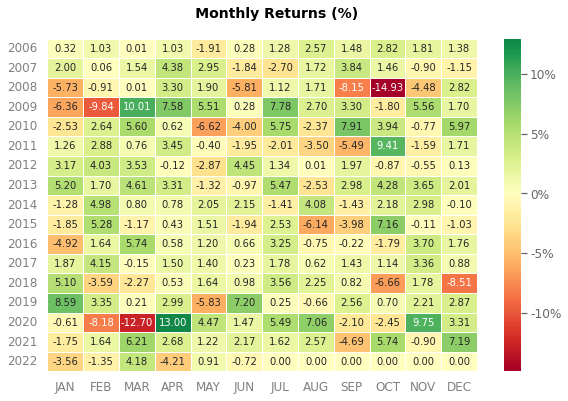

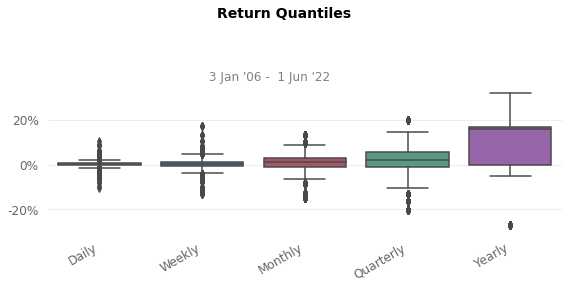

In [63]:
quantstats.reports.full(returns=my_strategy, benchmark=bm_strategy)